In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Cluster number selection.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [693]:
import pickle

# # FC data
# my_deepof_project = deepof.data.load_project("./deepof_FC_project_files/")

# with open("./deepof_FC_project_files/Coordinates/FC_dataset_experimental_conditions.pkl", "rb") as handle:
#     exp_conditions = pickle.load(handle)
# my_deepof_project._exp_conditions = exp_conditions

# SI data
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_SI/deepof_SI_project/")
with open("deepof_SI_exp_conds.pkl", "rb") as handle:
    exp_conds = pickle.load(handle)
my_deepof_project._exp_conditions = exp_conds

# Update project path to a local path
my_deepof_project._project_path = "../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_SI/"
my_deepof_project._project_name = "deepof_SI_project"

In [5]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

# tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# tt, _ = tt.preprocess(
#     window_size=13,
#     window_step=1,
#     test_videos=1,
#     scale="standard",
#     handle_ids="split", # "concat" uses bps from != animals as features, "split"
# )

In [36]:
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

# pp, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
#     animal_id="B",
#     center="Center",
#     align="Spine_1",
#     window_size=25,
#     window_step=1,
#     preprocess=True,
#     scale="standard"
# )

# adj = nx.adjacency_matrix(G).todense()

# with open("graph_processed_dataset.pkl", "wb") as handle:
#     pickle.dump([pp, G, to_preprocess, global_scaler], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Running an unsupervised analysis with default parameters

In [ ]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="VaDE",
    epochs=2,
    encoder_type="recurrent",
    n_components=10,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
    pretrained="deepof_FC_project_files/Trained_models/train_models/trained_weights/deepof_unsupervised_VaDE_recurrent_encodings_input_type=graph_kmeans_loss=0.0_encoding=4_k=10_run=1_final_weights.h5",
)

In [649]:
# Load results
import pickle
with open(
    "NatComm_trained_sadeepOF_SI/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=8_changepoints_False_kmeans_loss=0.0_run=0.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)

In [650]:
embeddings = {key: val.numpy() for key, val in embeddings.items()}
soft_counts = {key: val.numpy() for key, val in soft_counts.items()}
breaks = {key: np.ones(soft_counts[key].shape[0]).astype(int) for key in soft_counts.keys()}

### Understanding the different available models

In [48]:
# cons.vade.summary()

### Cluster number selection

In [639]:
from collections import defaultdict

# For each computed model, train a logistic regression able to predict the class (CSDS / NS) based on the vector of
# cluster population per video. Use the performance of the classifier as a metric for model selection
def get_cluster_selection_training_data(
    # Model selection parameters
    deepof_project,
    min_clusters=5,
    max_clusters=25,
    max_id=5,
):

    meta_counts = defaultdict(list)
    labels = None

    # Iteratively load all the models in question and set
    for cluster_number in range(min_clusters, max_clusters + 1):

        for run_id in range(max_id):
            
            try:
                # Load model results
                emb_path = "./NatComm_trained_sadeepOF_SI/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k={}_latdim=8_changepoints_False_kmeans_loss=0.0_run={}.pkl".format(
                    cluster_number,
                    run_id,
                )


                with open(emb_path, "rb") as handle:
                    _, soft_counts, breaks = pickle.load(handle)

                if labels is None:
                    labels = np.array(
                        [
                            deepof_project.get_exp_conditions[key]
                            for key in soft_counts.keys()
                        ]
                    )

                time_on_cluster = deepof.post_hoc.get_time_on_cluster(soft_counts, breaks)
                meta_counts["{}_{}".format(cluster_number, run_id)] = np.stack(
                    [tab for tab in time_on_cluster.values]
                )

            except FileNotFoundError:
                continue

    return meta_counts, labels.flatten()

In [640]:
%%time
model_selection_X, model_selection_y = get_cluster_selection_training_data(my_deepof_project)

CPU times: user 1min 24s, sys: 1.67 s, total: 1min 25s
Wall time: 1min 27s


In [644]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def train_cluster_selection_classifiers(X_dict, y):

    auc_dict = defaultdict(list)

    for key, X in tqdm.tqdm(X_dict.items()):

        clf = LogisticRegression(penalty=None)
        clf.fit(X, y)

        auc_dict[key.split("_")[0]].append(roc_auc_score(y, clf.predict_proba(X)[:, 1]))
        
    max_keys = np.max([len(v) for v in auc_dict.values()])
    for key, val in auc_dict.items():
        for j in range(max_keys - len(val)):
            auc_dict[key].append(np.nan)

    return pd.DataFrame(auc_dict).melt(var_name="number of clusters", value_name="AUC")

In [645]:
%%time
import tqdm
model_selection = train_cluster_selection_classifiers(model_selection_X, model_selection_y)
agg = model_selection.groupby("number of clusters").AUC.median()
agg.index = agg.index.astype(int)
agg.sort_index(inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 423.88it/s]

CPU times: user 167 ms, sys: 4.73 ms, total: 172 ms
Wall time: 175 ms


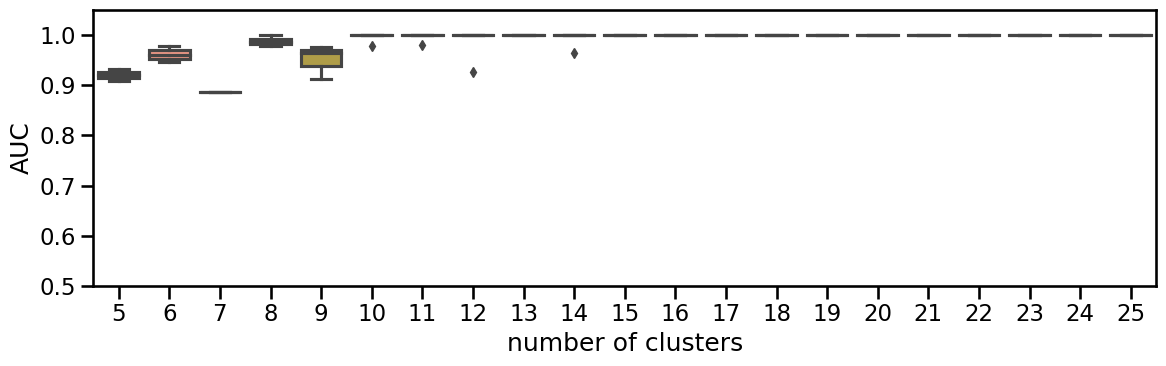

In [648]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.boxplot(data=model_selection, x="number of clusters", y="AUC")

plt.ylim(0.5, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
model_selection.groupby("number of clusters").AUC.median()

### Visualizing temporal and global embeddings

In [49]:
# INCORPORATE AS A METHOD FOR EACH MODEL
# embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)

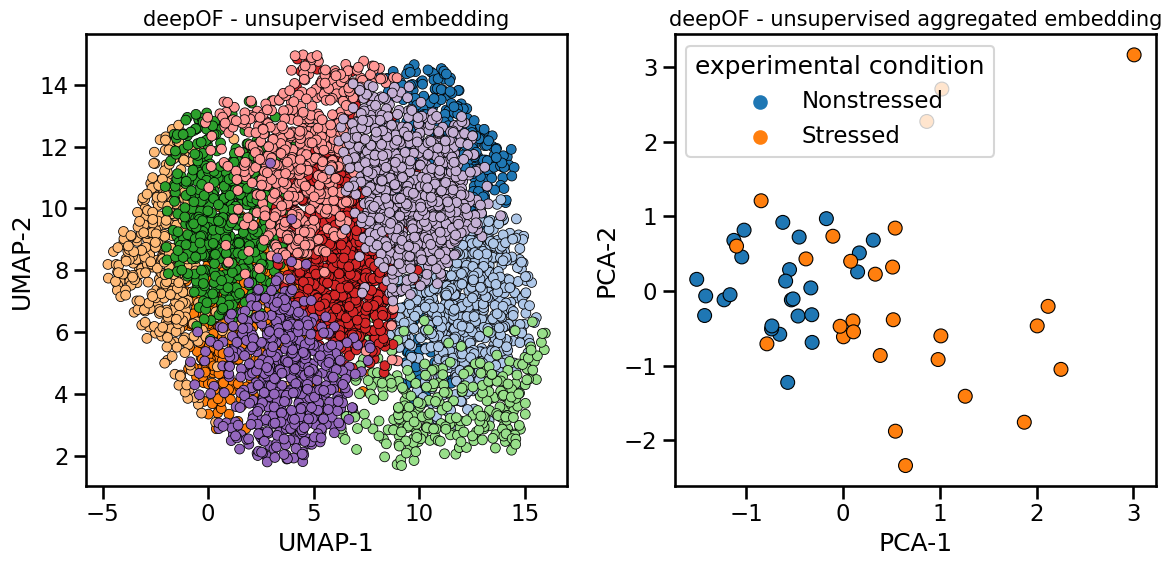

In [651]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=100,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="CSDS",
    show_aggregated_density=False,
#     bin_index=4,
#     bin_size=25*120,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

In [688]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191203_Day1_SI_JB08_Test_5",
    frame_limit=150,
    selected_cluster=1,
    dpi=60,
    center="arena",    
)

html = display.HTML(video)
display.display(html)
plt.close()

In [689]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191203_Day1_SI_JB08_Test_13",
    frame_limit=150,
    selected_cluster=4,
    dpi=60,
    center="arena",
)

html = display.HTML(video)
display.display(html)
plt.close()

### Global separation dynamics

Found an optimal_bin at 126 seconds


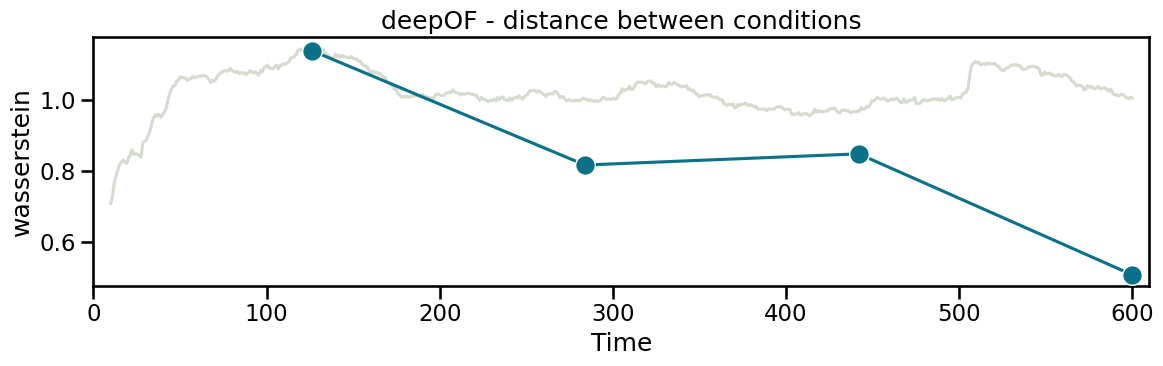

CPU times: user 4.57 s, sys: 17.1 s, total: 21.6 s
Wall time: 1min 34s


In [692]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
deepof.visuals.plot_distance_between_conditions(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    "CSDS",
    distance_metric="wasserstein",
    n_jobs=-1,
)

plt.show()

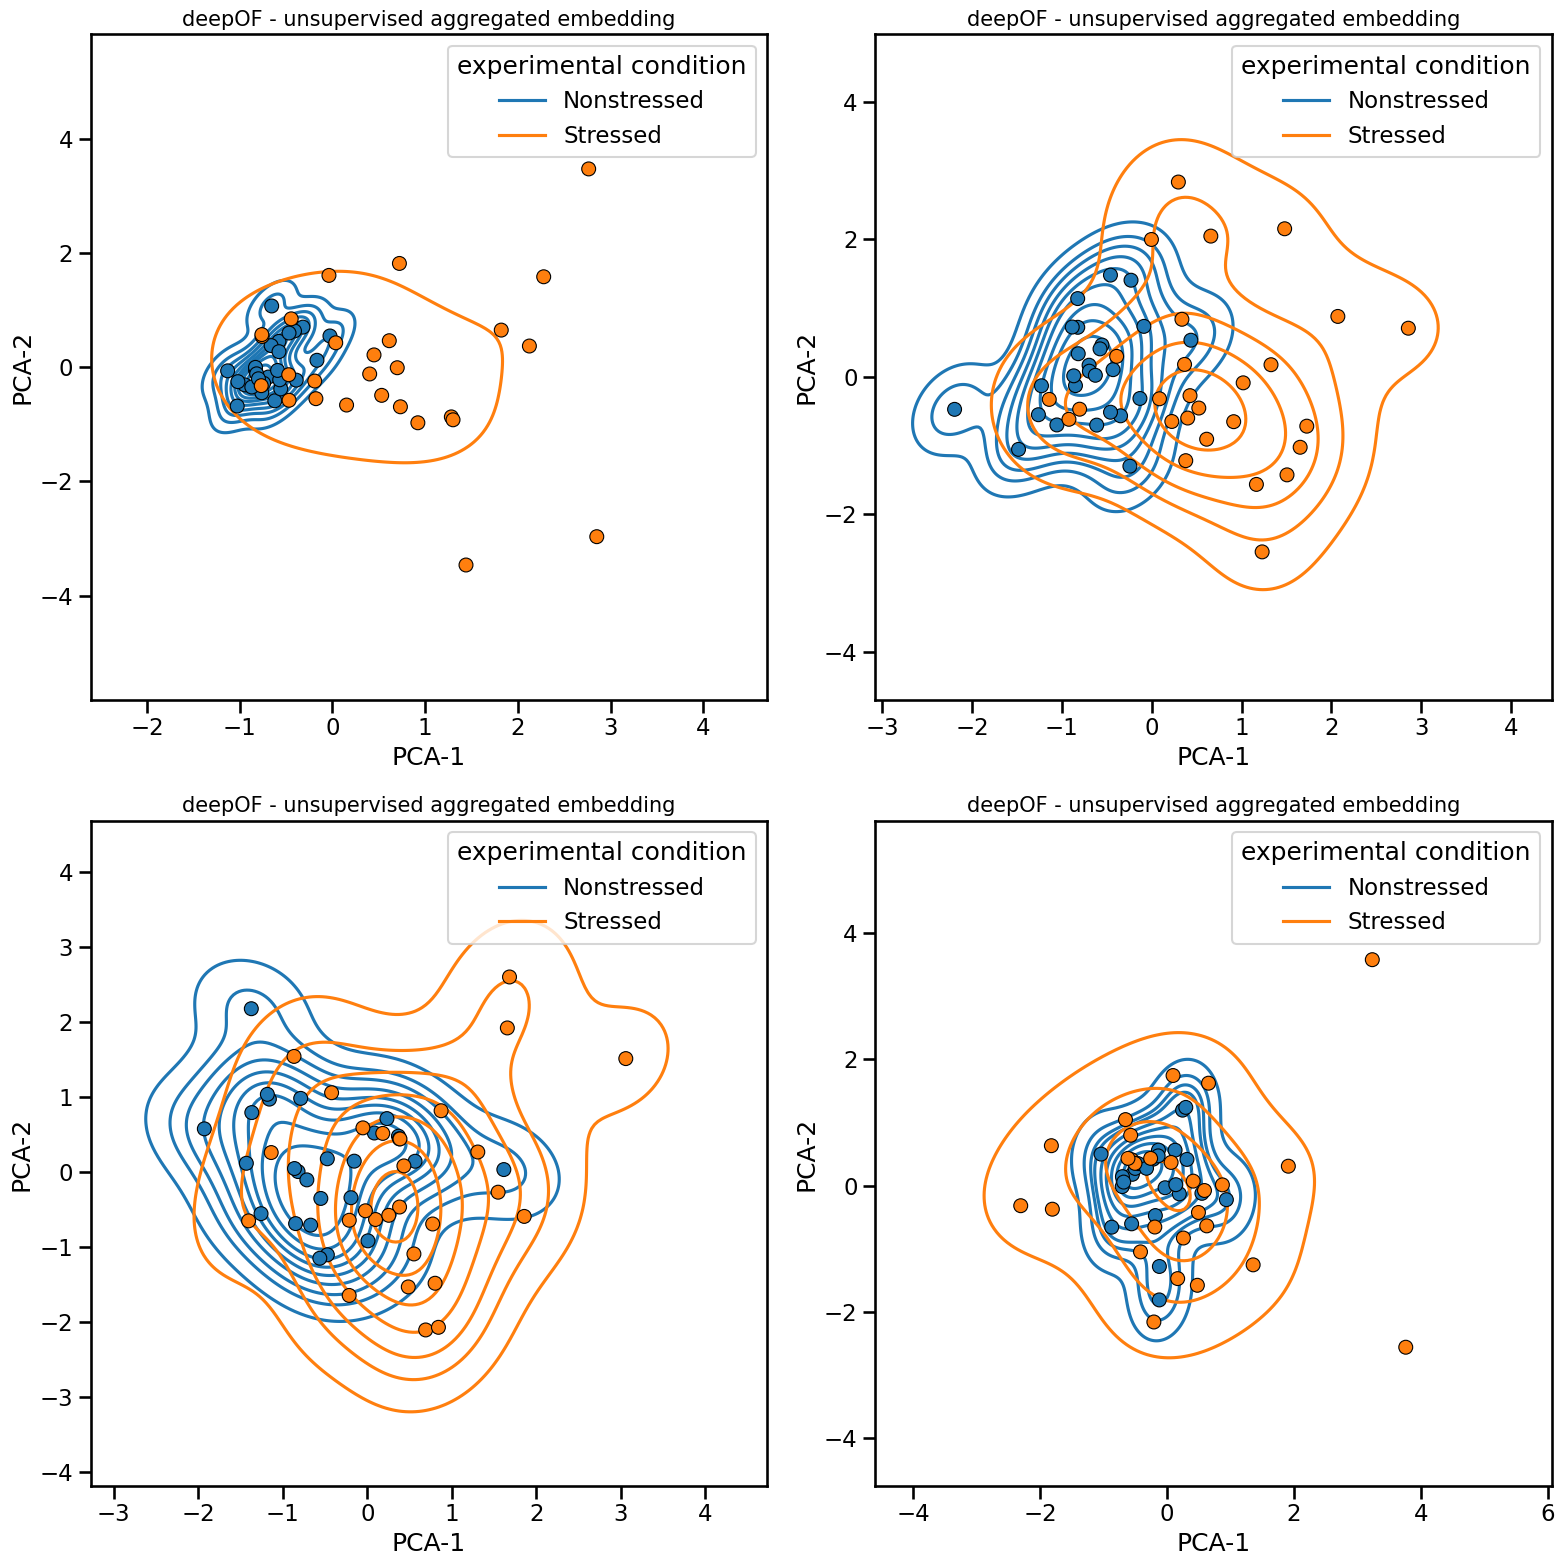

In [669]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))


for i, ax in zip(range(4), [ax1, ax2, ax3, ax4]):

    deepof.visuals.plot_embeddings(
        my_deepof_project,
        embeddings, 
        soft_counts,
        breaks,
        aggregate_experiments="time on cluster",
        exp_condition="CSDS",
        show_aggregated_density=True,
        bin_index=i,
        bin_size=126,
        ax=ax,
        save=False, # Set to True, or give a custom name, to save the plot,
    )

plt.tight_layout()
plt.show()

### Exploring cluster enrichment across conditions

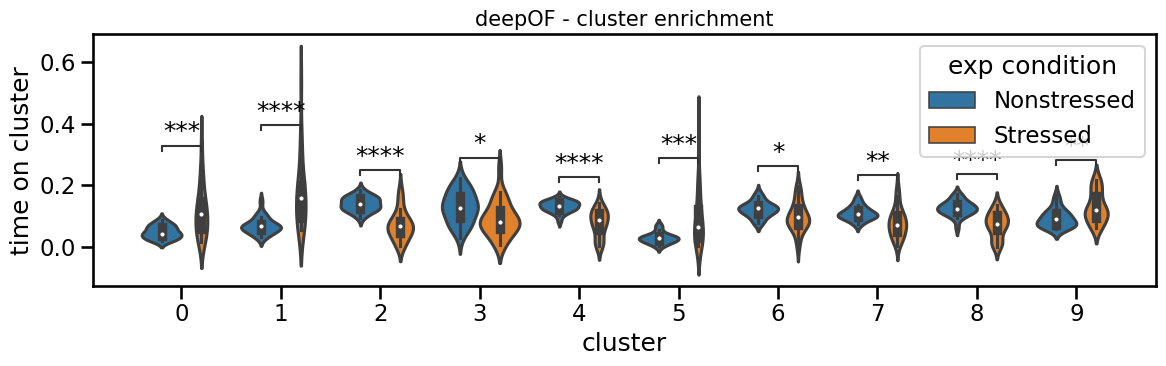

In [672]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_cluster_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    normalize=True,
    bin_size=126,
    bin_index=0,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax,
)

### Exploring cluster dynamics across conditions

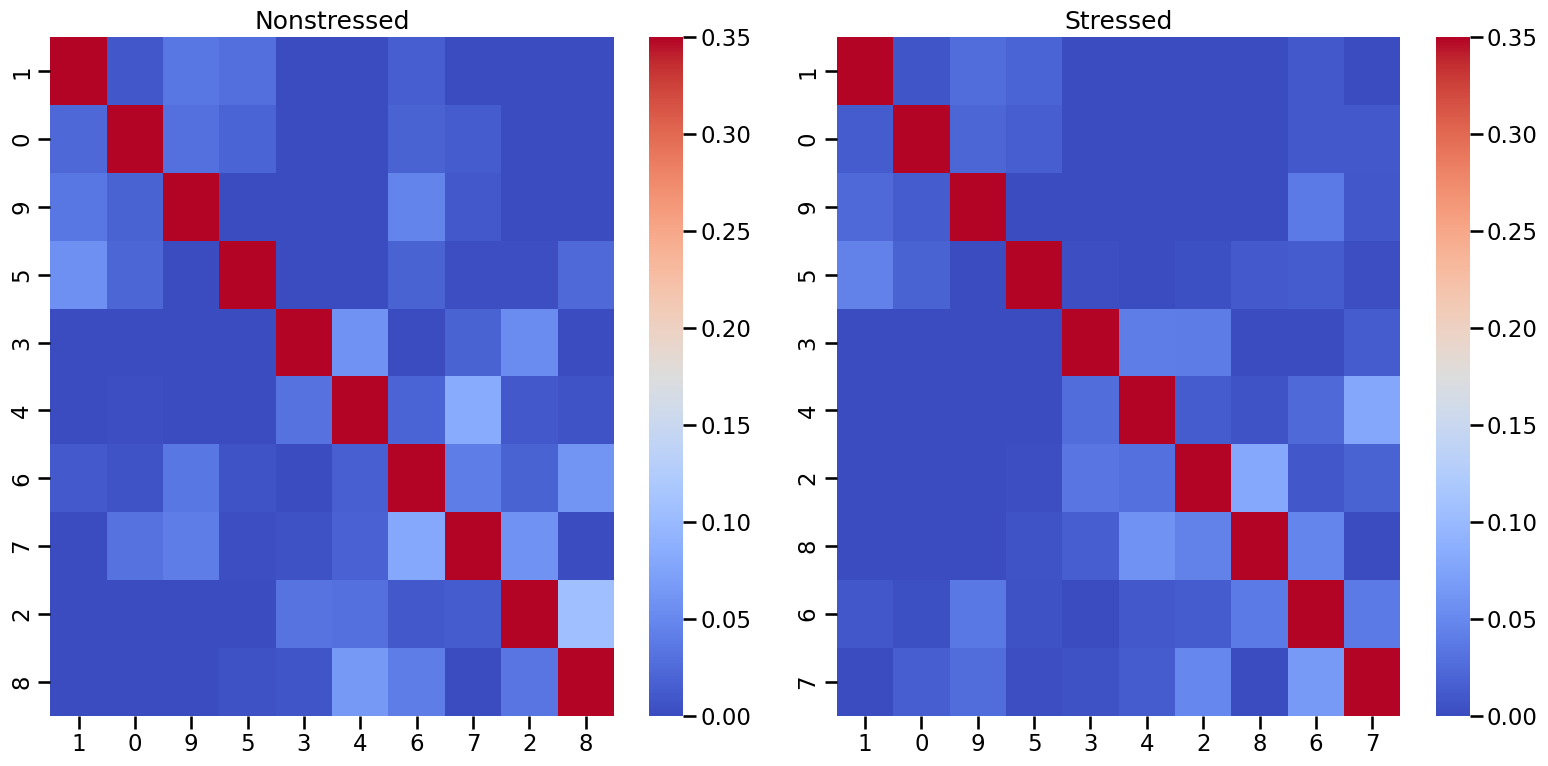

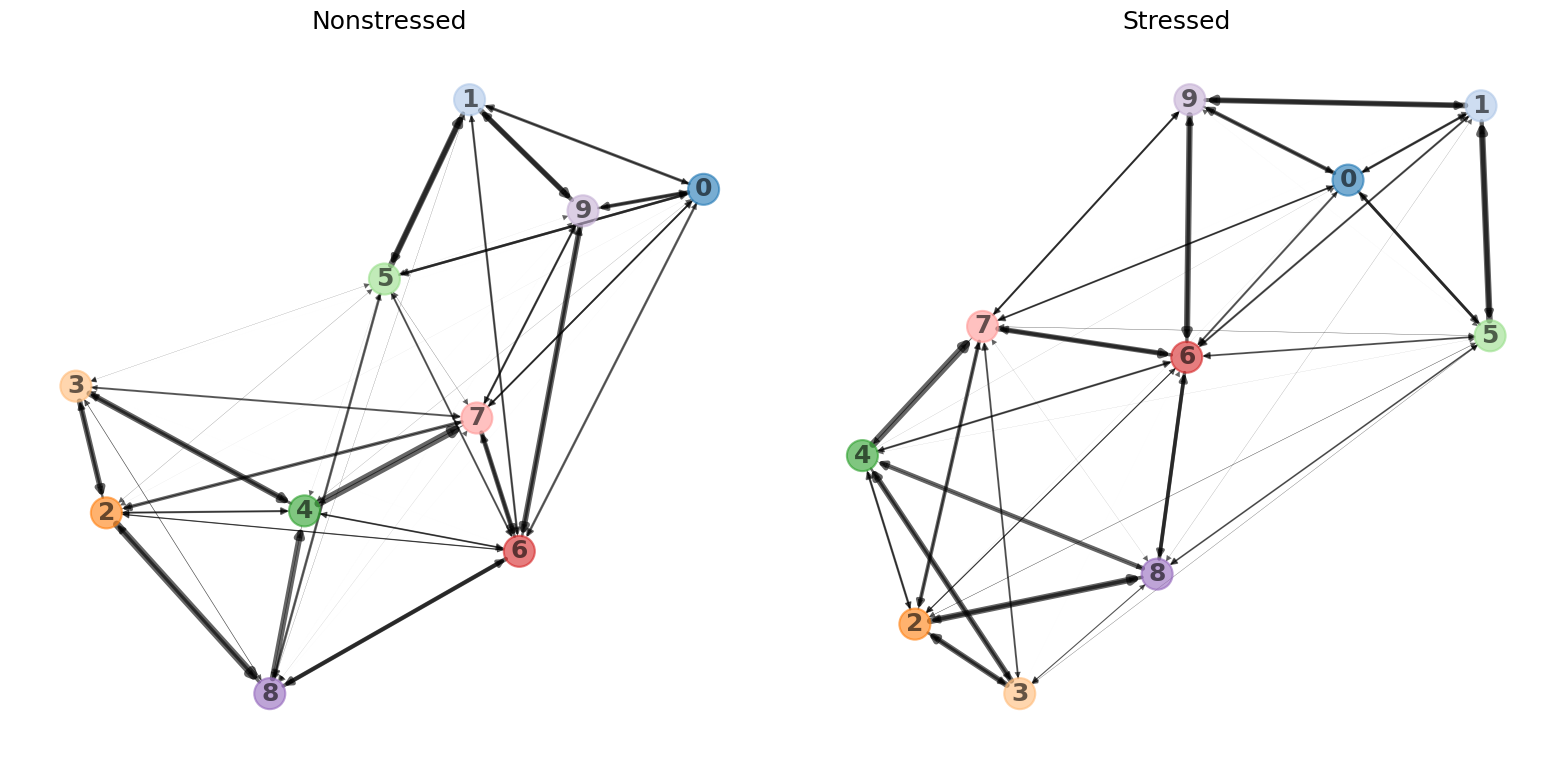

In [673]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="CSDS",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="CSDS",
)

# TODO:

# Add option to use umap location on network plots

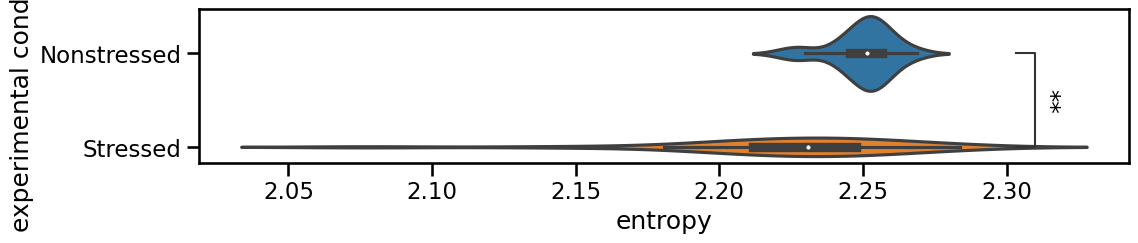

In [674]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="CSDS",
    ax=ax,
)

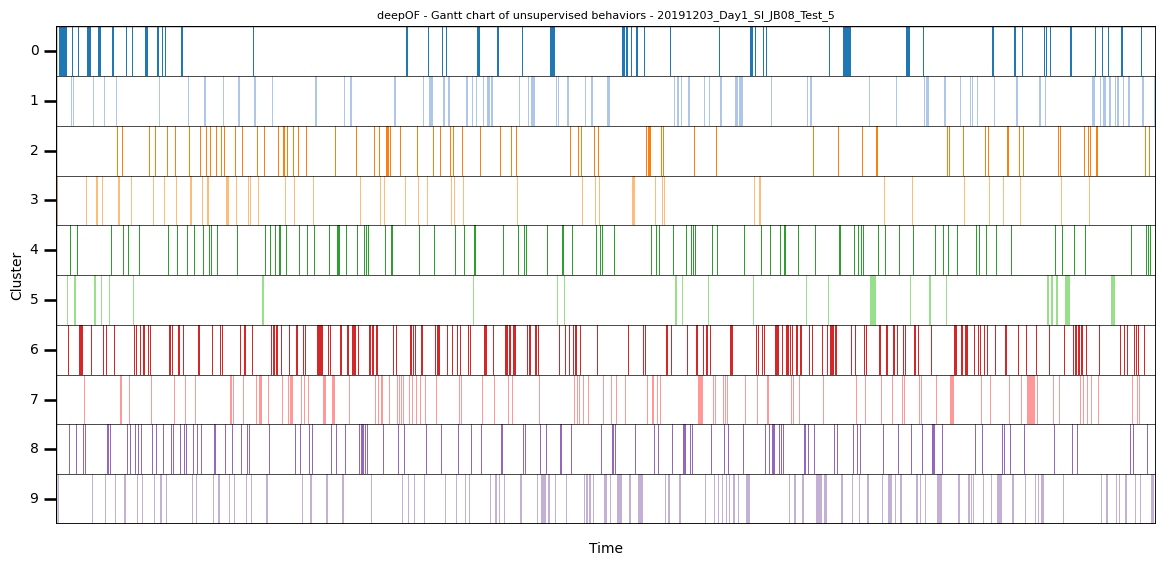

In [675]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt( # TODO: Add X axis in seconds, and parameter to overlay events as vertical black bars!
    my_deepof_project, # TODO: restrict time span! it looks noisy
    soft_counts=soft_counts,
    experiment_id="20191203_Day1_SI_JB08_Test_5",
)

### Combining supervised and unsupervised information

#### Visualize global embeddings using the retrieved traits.

#### Visualize animated unsupervised embeddings, coloured by specific traits.

### Interpreting clusters using SHAP

In [680]:
%%time
csds_chunk_stats, hard_counts, sampled_breaks = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    window_size=13,
    include_distances=True,
    min_confidence=0.9,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
    samples=1500,
)

In [ ]:
%%time
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_breaks, n_folds=5, verbose=2,
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("notebook")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("talk")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
    save=False,
)

In [ ]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=100
)

In [ ]:
from matplotlib import colors as plt_colors
from ipywidgets import interact
import copy
import numpy as np

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(10)), save=False,
):
    
    deepof.visuals.plot_shap_swarm_per_cluster(
        my_deepof_project, 
        data_to_explain, 
        shap_values, cluster, 
        save=save,
        show=False,
    )
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

### Exporting cluster video snippets

In [698]:
deepof.visuals.export_annotated_video( # TODO: add exp condition filters to output names
    my_deepof_project,
    soft_counts,
    breaks,
    min_confidence=0.5,
  #  exp_conditions=["Nonstressed"],
  #  experiment_id="Test_10_FA_JB06_2_cut",
)